# **K Nearest Neighbors**

**Import Libraries**

In [1]:
# ### 1. IMPORT LIBRARIES ###
print("Step 1: Importing libraries...")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay
)
import os

Step 1: Importing libraries...


**Load and Clean Dataset**

In [2]:
# ### 2. LOAD AND PREPROCESS THE DATASET ###
print("Step 2: Loading and preprocessing dataset...")
try:
    df = pd.read_csv("student_depression_dataset.csv")
except FileNotFoundError:
    print("Error: 'student_depression_dataset.csv' not found.")
    raise

# Drop irrelevant/high-cardinality columns
df = df.drop(columns=['id', 'City', 'Profession'])
print("Initial data loaded and irrelevant columns dropped.")
df.head()

Step 2: Loading and preprocessing dataset...
Initial data loaded and irrelevant columns dropped.


,Gender,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Male,33,5,0,8.97,2,0,'5-6 hours',Healthy,B.Pharm,Yes,3,1,No,1
1,Female,24,2,0,5.90,5,0,'5-6 hours',Moderate,BSc,No,3,2,Yes,0
2,Male,31,3,0,7.03,5,0,'Less than 5 hours',Healthy,BA,No,9,1,Yes,0
3,Female,28,3,0,5.59,2,0,'7-8 hours',Moderate,BCA,Yes,4,5,Yes,1
4,Female,25,4,0,8.13,3,0,'5-6 hours',Moderate,M.Tech,Yes,1,1,No,0


**Handle Missing Values**

In [3]:
print("Handling missing values ('?')...")

# Replace '?' with NaN and convert to numeric
df['Financial Stress'] = pd.to_numeric(
    df['Financial Stress'].replace('?', np.nan), errors='coerce'
)
df['Work/Study Hours'] = pd.to_numeric(
    df['Work/Study Hours'].replace('?', np.nan), errors='coerce'
)

# Impute NaN with the median
df['Financial Stress'] = df['Financial Stress'].fillna(
    df['Financial Stress'].median()
)
df['Work/Study Hours'] = df['Work/Study Hours'].fillna(
    df['Work/Study Hours'].median()
)

# Rename target variable for clarity
df = df.rename(columns={'Depression': 'Depression_Target'})

print("Missing values imputed with median.")
df.info()

Handling missing values ('?')...
Missing values imputed with median.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 15 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Gender                                 27901 non-null  object 
 1   Age                                    27901 non-null  int64  
 2   Academic Pressure                      27901 non-null  int64  
 3   Work Pressure                          27901 non-null  int64  
 4   CGPA                                   27901 non-null  float64
 5   Study Satisfaction                     27901 non-null  int64  
 6   Job Satisfaction                       27901 non-null  int64  
 7   Sleep Duration                         27901 non-null  object 
 8   Dietary Habits                         27901 non-null  object 
 9   Degree                                 27901 non-null  object 
 10  H

**Box plot**

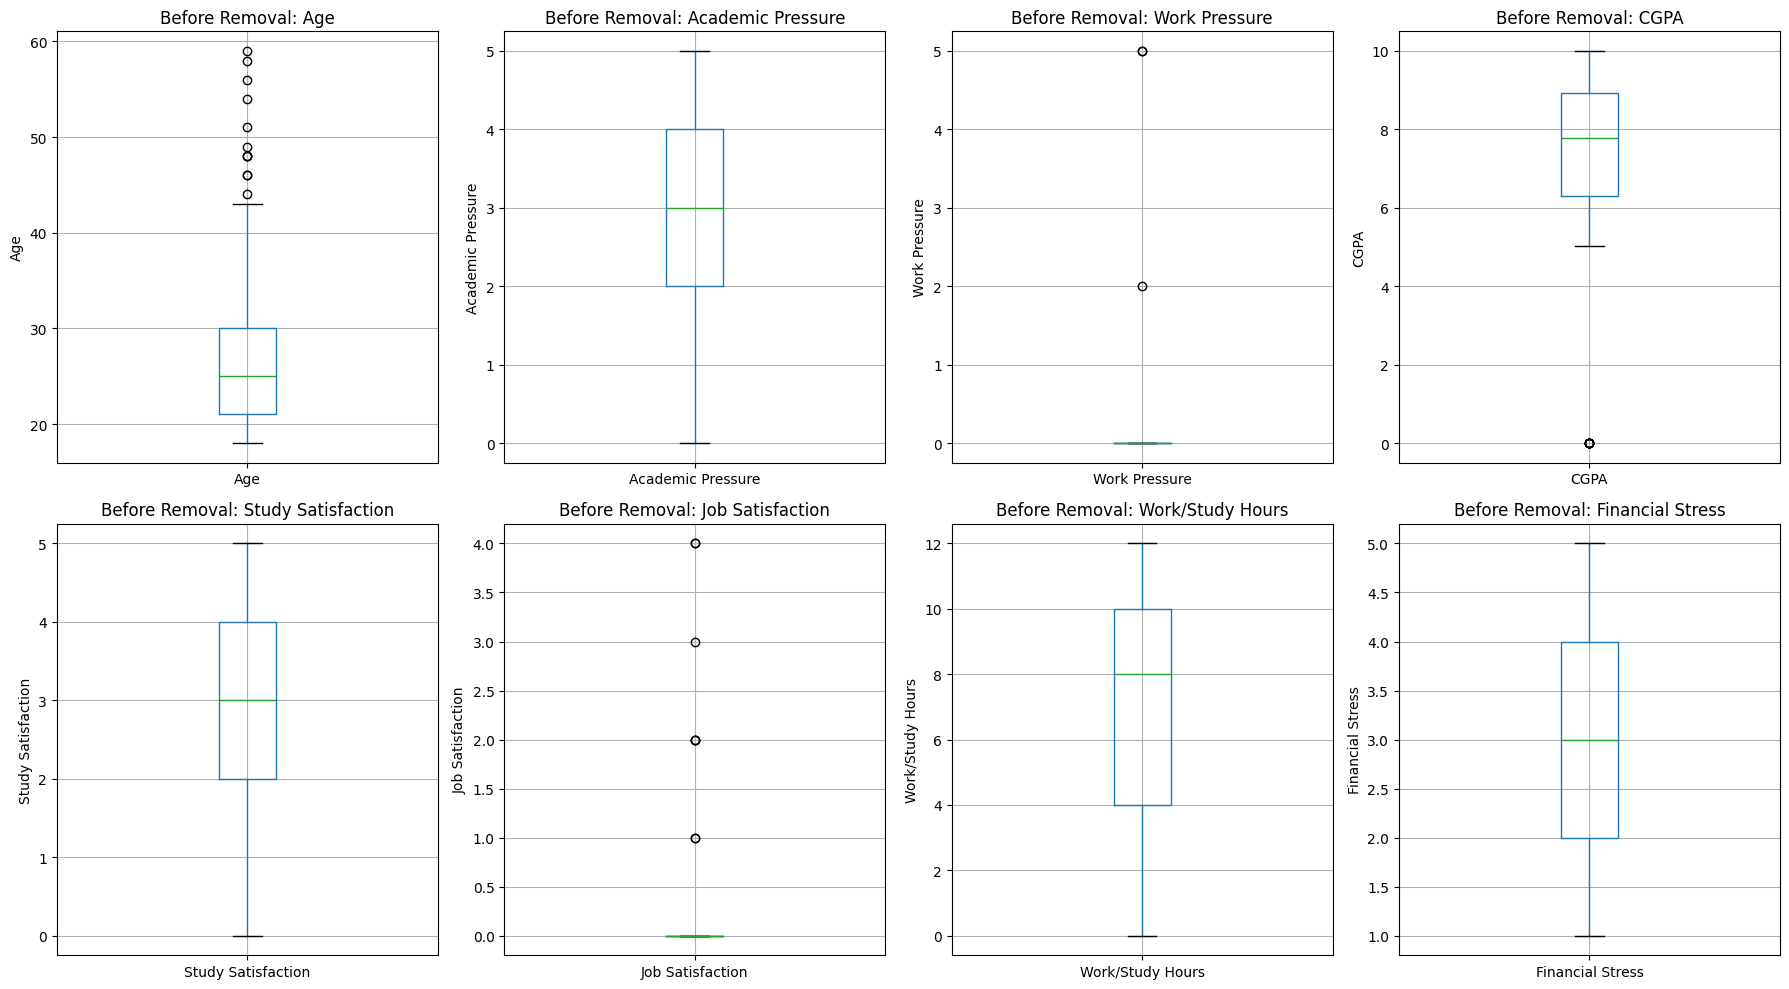

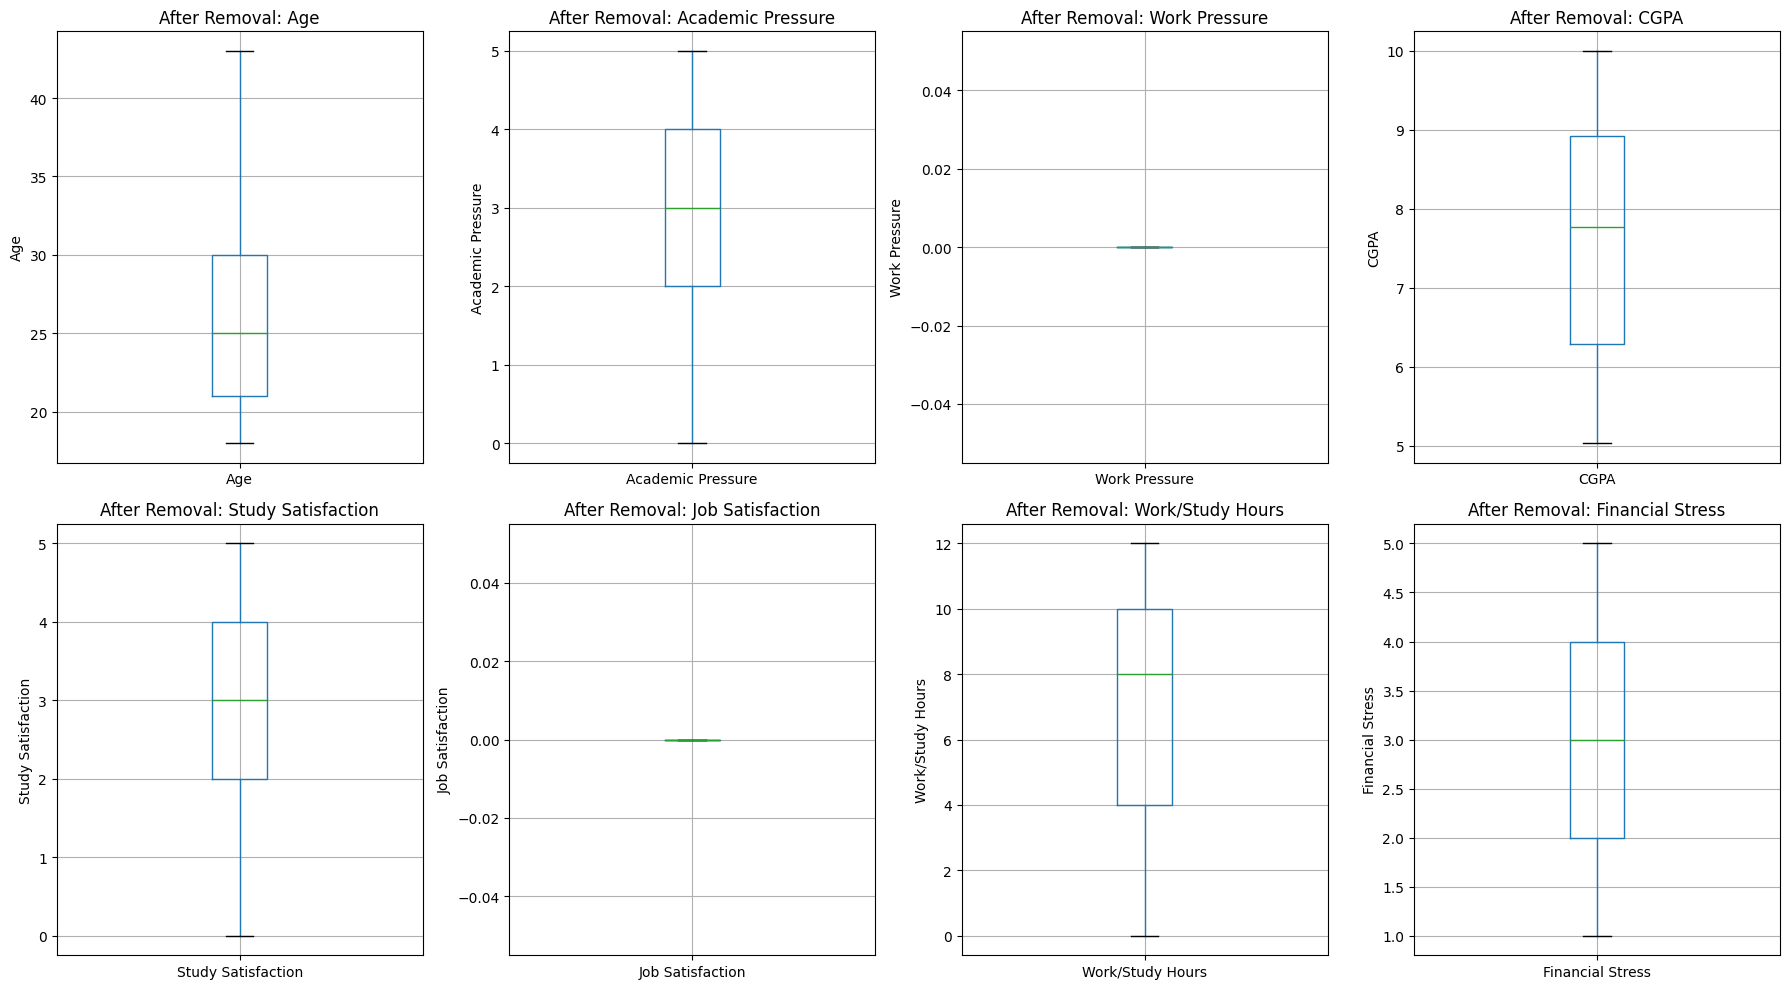

In [20]:
# Box Plots BEFORE Outlier Removal
plt.figure(figsize=(18, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 4, i + 1)
    df.boxplot(column=col)
    plt.title(f'Before Removal: {col}', fontsize=12)
    plt.ylabel(col)
plt.tight_layout()
plt.show()
plt.savefig('box_plots_before_outlier_removal.png')
plt.close()

# Box Plots AFTER Outlier Removal
plt.figure(figsize=(18, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 4, i + 1)
    df_cleaned.boxplot(column=col)
    plt.title(f'After Removal: {col}', fontsize=12)
    plt.ylabel(col)
plt.tight_layout()
plt.show()
plt.savefig('box_plots_after_outlier_removal.png')
plt.close()

**Outlier Removal**

In [5]:
# --- Outlier Removal (IQR Method) ---
print("Step 3: Removing outliers...")
numerical_cols = [
    'Age', 'Academic Pressure', 'Work Pressure', 'CGPA',
    'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'Financial Stress'
]
df_cleaned = df.copy()
original_rows = len(df_cleaned)

for col in numerical_cols:
    Q1 = df_cleaned[col].quantile(0.25)
    Q3 = df_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_cleaned = df_cleaned[
        (df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)
    ]

print(f"Rows before outlier removal: {original_rows}")
print(f"Rows after outlier removal: {len(df_cleaned)}")

Step 3: Removing outliers...
Rows before outlier removal: 27901
Rows after outlier removal: 27878


**Encode Categorical Features**

In [6]:
# --- Encoding Categorical Features ---
print("Step 4: Encoding categorical features...")
df_processed = df_cleaned.copy()

# Binary features: Use LabelEncoder
binary_cols = [
    'Gender', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness'
]
le = LabelEncoder()
for col in binary_cols:
    df_processed[col] = le.fit_transform(df_processed[col])

# Nominal features: Use One-Hot Encoding (pd.get_dummies)
nominal_cols = ['Sleep Duration', 'Dietary Habits', 'Degree']
df_processed = pd.get_dummies(
    df_processed, columns=nominal_cols, drop_first=True, dtype=int
)

print("Encoding complete.")
df_processed.head()

Step 4: Encoding categorical features...
Encoding complete.


,Gender,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,...,Degree_MA,Degree_MBA,Degree_MBBS,Degree_MCA,Degree_MD,Degree_ME,Degree_MHM,Degree_MSc,Degree_Others,Degree_PhD
0,1,33,5,0,8.97,2,0,1,3,1.0,...,0,0,0,0,0,0,0,0,0,0
1,0,24,2,0,5.90,5,0,0,3,2.0,...,0,0,0,0,0,0,0,0,0,0
2,1,31,3,0,7.03,5,0,0,9,1.0,...,0,0,0,0,0,0,0,0,0,0
3,0,28,3,0,5.59,2,0,1,4,5.0,...,0,0,0,0,0,0,0,0,0,0
4,0,25,4,0,8.13,3,0,1,1,1.0,...,0,0,0,0,0,0,0,0,0,0


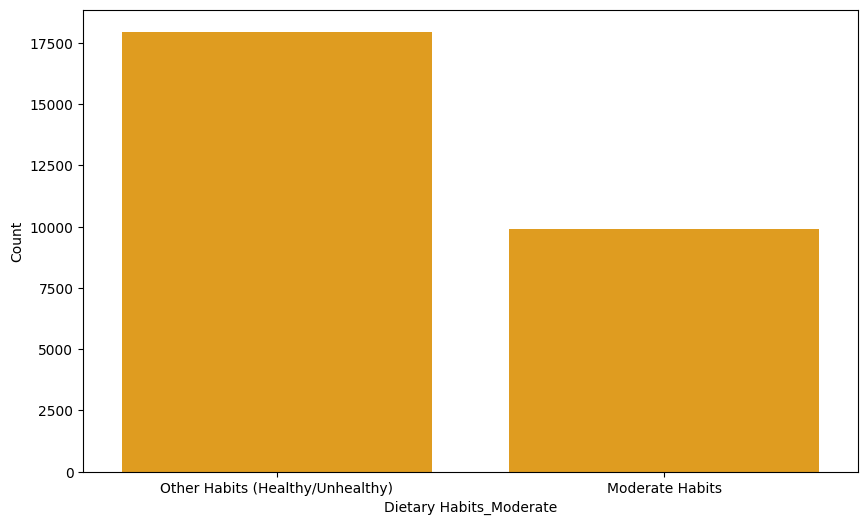

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
# Create bar chart
plt.figure(figsize=(10, 6))
# Use one of your one-hot encoded columns, e.g., 'Dietary Habits_Moderate'
sns.countplot(x='Dietary Habits_Moderate', data=df_processed, color='orange')
plt.ylabel('Count')
# Customize labels for readability
plt.xticks(ticks=[0, 1], labels=['Other Habits (Healthy/Unhealthy)', 'Moderate Habits'])
plt.savefig('moderate_diet_distribution.png', dpi=300)
plt.show()
plt.close()

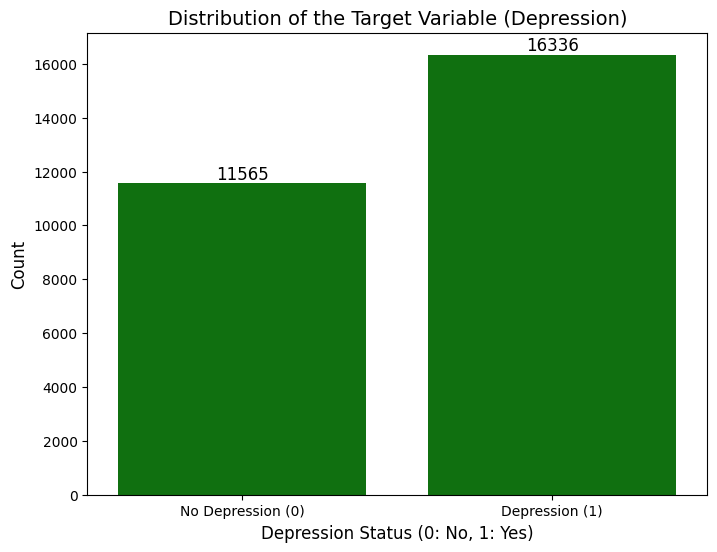

In [8]:
# Create the countplot for the 'Depression' target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='Depression_Target', data=df, color='green')
plt.title('Distribution of the Target Variable (Depression)', fontsize=14)
plt.xlabel('Depression Status (0: No, 1: Yes)', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Set custom x-tick labels for clarity
plt.xticks(ticks=[0, 1], labels=['No Depression (0)', 'Depression (1)'])

# Add counts on top of bars for exact numbers (optional but helpful)
ax = plt.gca()
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(),
            '%d' % int(p.get_height()),
            fontsize=12, color='black', ha='center', va='bottom')

plt.savefig('target_distribution.png', dpi=300)
plt.show()
plt.close()

**Display preprocessed data**

In [9]:
display(df_processed)

,Gender,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,...,Degree_MA,Degree_MBA,Degree_MBBS,Degree_MCA,Degree_MD,Degree_ME,Degree_MHM,Degree_MSc,Degree_Others,Degree_PhD
0,1,33,5,0,8.97,2,0,1,3,1.0,...,0,0,0,0,0,0,0,0,0,0
1,0,24,2,0,5.90,5,0,0,3,2.0,...,0,0,0,0,0,0,0,0,0,0
2,1,31,3,0,7.03,5,0,0,9,1.0,...,0,0,0,0,0,0,0,0,0,0
3,0,28,3,0,5.59,2,0,1,4,5.0,...,0,0,0,0,0,0,0,0,0,0
4,0,25,4,0,8.13,3,0,1,1,1.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27896,0,27,5,0,5.75,5,0,1,7,1.0,...,0,0,0,0,0,0,0,0,0,0
27897,1,27,2,0,9.40,3,0,0,0,3.0,...,0,0,0,0,0,0,0,1,0,0
27898,1,31,3,0,6.61,4,0,0,12,2.0,...,0,0,0,0,1,0,0,0,0,0
27899,0,18,5,0,6.88,2,0,1,10,5.0,...,0,0,0,0,0,0,0,0,0,0


**Feature Selection**

In [10]:
# --- Feature Selection ---
print("Step 5: Performing feature selection...")

# Drop columns with zero variance (constants)
# We add errors='ignore' so this cell can be re-run without crashing
df_processed = df_processed.drop(
    columns=['Work Pressure', 'Job Satisfaction'], 
    errors='ignore'
)

# Define features (X) and target (y)
TARGET_COLUMN = 'Depression_Target'
y = df_processed[TARGET_COLUMN]
X = df_processed.drop(columns=[TARGET_COLUMN])

# Apply SelectKBest to get top 10 features
k_best = SelectKBest(score_func=f_classif, k=10)
k_best.fit(X, y) # Just .fit() the data

# Get selected feature names
selected_indices = k_best.get_support(indices=True)
FEATURE_COLUMNS = X.columns[selected_indices].tolist()

print(f"Selected features: {FEATURE_COLUMNS}")

# CRITICAL FIX: 
# Re-assign X to be *only* the selected feature columns
# This preserves the original index, keeping X and y aligned.
X = X[FEATURE_COLUMNS]

Step 5: Performing feature selection...
Selected features: ['Age', 'Academic Pressure', 'Study Satisfaction', 'Have you ever had suicidal thoughts ?', 'Work/Study Hours', 'Financial Stress', 'Family History of Mental Illness', "Sleep Duration_'Less than 5 hours'", "Sleep Duration_'More than 8 hours'", 'Dietary Habits_Unhealthy']


**Split and Scale Data**

In [11]:
# ### 7. SPLIT AND SCALE THE DATA ###
print("Step 7: Splitting and scaling data...")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert back to DataFrame for clarity (this helps prevent warnings later)
X_train = pd.DataFrame(X_train, columns=FEATURE_COLUMNS)
X_test = pd.DataFrame(X_test, columns=FEATURE_COLUMNS)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Step 7: Splitting and scaling data...
Training data shape: (22302, 10)
Testing data shape: (5576, 10)


**Train & Evaluate Default KNN (BEFORE Tuning)**

In [12]:
# ### 8. TRAIN & EVALUATE DEFAULT KNN (BEFORE TUNING) ###
print("\nStep 8: Training default KNN (Before Tuning)...")

# 1. Create a default KNN model (a common default is k=5)
knn_default = KNeighborsClassifier(n_neighbors=5)

# 2. Fit it on the training data
knn_default.fit(X_train, y_train)

# 3. Make predictions on the test set
y_pred_default = knn_default.predict(X_test)

# 4. Calculate and store the "before" accuracy
accuracy_before = accuracy_score(y_test, y_pred_default)

print(f"\nDefault KNN (k=5) Test Set Accuracy: {accuracy_before * 100:.2f}%")
print("This is the 'Before Tuning' score.")


Step 8: Training default KNN (Before Tuning)...

Default KNN (k=5) Test Set Accuracy: 82.51%
This is the 'Before Tuning' score.


**Define KNN Model and Grid Search (for Tuning)**

In [13]:
# ### 9. DEFINE KNN MODEL AND GRIDSEARCH (FOR TUNING) ###
print("\nStep 9: Defining KNN model and GridSearchCV for Tuning...")

# 1. Define the model
knn = KNeighborsClassifier()

# 2. Define the parameter grid to search
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15]
}

# 3. Set up the Grid Search
print("Setting up GridSearchCV with n_jobs=1 (to prevent multiprocessing errors)...")
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=5,                         # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=1,                     # <-- FIX for _posixsubprocess error
    verbose=1
)


Step 9: Defining KNN model and GridSearchCV for Tuning...
Setting up GridSearchCV with n_jobs=1 (to prevent multiprocessing errors)...


**Run Grid Search**

In [14]:
# ### 10. RUN GRIDSEARCH ###
print("Running grid_search.fit()...")

# 4. Run the search on the training data
grid_search.fit(X_train, y_train)

# 5. Get the best model and its parameters
print("\nGrid search complete.")
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_ * 100:.2f}%")

# 6. Set the 'model' variable to the best estimator found
model = grid_search.best_estimator_

Running grid_search.fit()...
Fitting 5 folds for each of 7 candidates, totalling 35 fits

Grid search complete.
Best parameters found: {'n_neighbors': 15}
Best cross-validation accuracy: 83.48%


**Evaluate Tuned Model (Metrics)**

In [15]:
# ### 11. EVALUATE THE (TUNED) MODEL ###
print("\nStep 11: Evaluating the best (Tuned) KNN model on the test set...")

# Make predictions on the test data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1] # Prob for positive class

# Calculate and store the "after" accuracy
accuracy_after = accuracy_score(y_test, y_pred)
best_k = model.n_neighbors # Get the best 'k' for labels
print(f"Tuned KNN (k={best_k}) Test Set Accuracy: {accuracy_after * 100:.2f}%")
print("This is the 'After Tuning' score.")

# --- Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Depression', 'Depression']))

# --- Confusion Matrix ---
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)


Step 11: Evaluating the best (Tuned) KNN model on the test set...
Tuned KNN (k=15) Test Set Accuracy: 83.64%
This is the 'After Tuning' score.

Classification Report:
               precision    recall  f1-score   support

No Depression       0.83      0.77      0.79      2310
   Depression       0.84      0.89      0.86      3266

     accuracy                           0.84      5576
    macro avg       0.83      0.83      0.83      5576
 weighted avg       0.84      0.84      0.84      5576


Confusion Matrix:
[[1768  542]
 [ 370 2896]]


**Plot Accuracy Comparison (Before vs. After)**


Step 12: Plotting accuracy comparison...


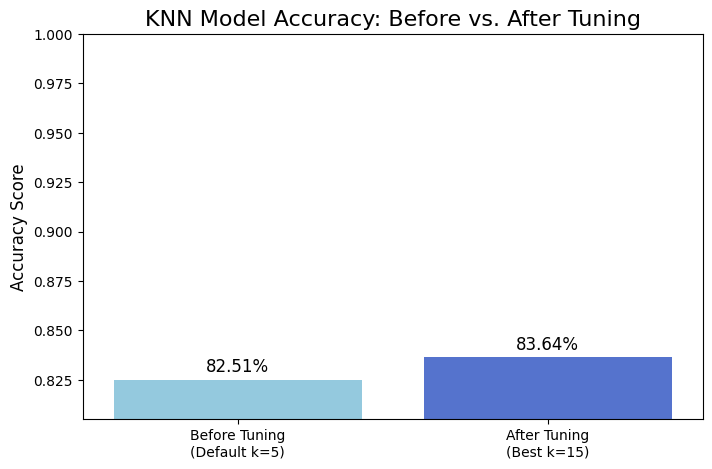

Saved accuracy_comparison.png


In [16]:
# ### 12. PLOT ACCURACY COMPARISON ###
print("\nStep 12: Plotting accuracy comparison...")

# Get the 'k' value from the best model for a nice label
best_k = model.n_neighbors

# Create labels and accuracy values for the plot
labels = [f'Before Tuning\n(Default k=5)', f'After Tuning\n(Best k={best_k})']
accuracies = [accuracy_before, accuracy_after]

# Plot the bar chart
plt.figure(figsize=(8, 5))

# --- THIS IS THE FIX ---
# We add hue=labels and legend=False as the warning suggests
barplot = sns.barplot(
    x=labels, 
    y=accuracies, 
    palette=['skyblue', 'royalblue'],
    hue=labels,        # <-- Assign x-variable (labels) to hue
    legend=False,      # <-- Turn off the legend
    dodge=False        # <-- Keep bars from splitting
)
# ---------------------

plt.title('KNN Model Accuracy: Before vs. After Tuning', fontsize=16)
plt.ylabel('Accuracy Score', fontsize=12)

# Set Y-axis limits to zoom in on the difference
plt.ylim(min(accuracies) - 0.02, 1.0) 

# Add the accuracy values on top of the bars
for p in barplot.patches:
    barplot.annotate(f'{p.get_height() * 100:.2f}%', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), 
                     textcoords = 'offset points',
                     fontsize=12)

# Save and show the plot
plt.savefig("accuracy_comparison.png")
plt.show()

print("Saved accuracy_comparison.png")

**Plot Confusion Matrix (Tuned Model)**


Plotting Confusion Matrix for Tuned Model...


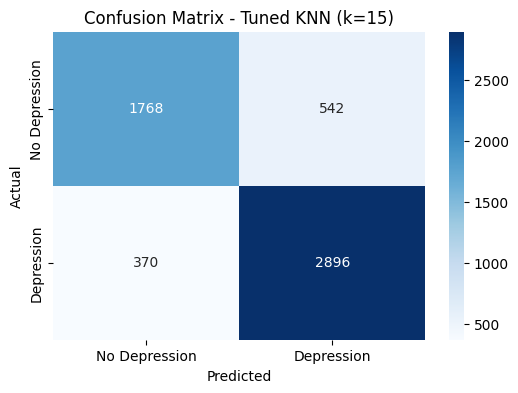

Saved confusion_matrix_knn_tuned.png


In [17]:
# ### 13. PLOT CONFUSION MATRIX (TUNED MODEL) ###
print("\nPlotting Confusion Matrix for Tuned Model...")
try:
    plt.figure(figsize=(6, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['No Depression', 'Depression'],
        yticklabels=['No Depression', 'Depression']
    )
    plt.title(f'Confusion Matrix - Tuned KNN (k={best_k})')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig("confusion_matrix_knn_tuned.png")
    plt.show() 
    print("Saved confusion_matrix_knn_tuned.png")
except Exception as e:
    print(f"Could not plot Confusion Matrix: {e}")

**Plot ROC Curve (Tuned Model)**


Plotting ROC Curve for Tuned Model...


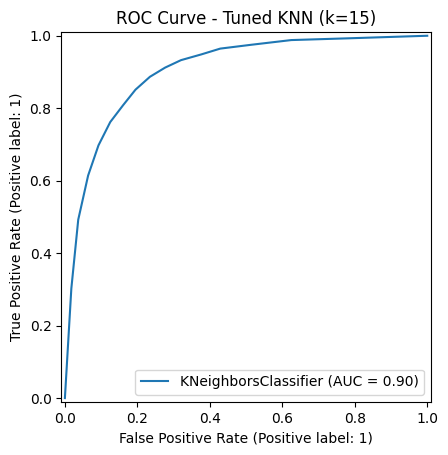

Saved roc_curve_knn_tuned.png


In [18]:
# ### 14. PLOT ROC CURVE (TUNED MODEL) ###
print("\nPlotting ROC Curve for Tuned Model...")
try:
    fig, ax = plt.subplots() 
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax)
    plt.title(f'ROC Curve - Tuned KNN (k={best_k})')
    plt.savefig("roc_curve_knn_tuned.png")
    plt.show() 
    print("Saved roc_curve_knn_tuned.png")
except Exception as e:
    print(f"Could not plot ROC curve: {e}")

**Test with New Data**

In [19]:
# ### 15. TEST WITH NEW DATA (Example) ###
print("\nStep 15: Example of testing with new data...")

# Create a DataFrame for new data, using the exact FEATURE_COLUMNS
# All values must be numbers (int or float)
new_patients_data = [
    # Patient 1: Low Risk Example
    [0, 1.0, 8.5, 5.0, 0, 3.0, 1.0, 0, 0, 0],
    # Patient 2: High Risk Example
    [1, 5.0, 5.1, 1.0, 1, 10.0, 5.0, 1, 1, 0]  # <--- CORRECTED: Replaced 'Moderate' with 0
]

new_patients_df = pd.DataFrame(new_patients_data, columns=FEATURE_COLUMNS)

# **Important**: Scale the new data using the *fitted* scaler
new_patients_scaled = scaler.transform(new_patients_df)

# --- FIX: Convert scaled array back to a DataFrame with feature names ---
# This prevents the "X does not have valid feature names" warning.
new_patients_scaled_df = pd.DataFrame(new_patients_scaled, columns=FEATURE_COLUMNS)
# ---------------------------------------------------------------------

# Predict classes using the new DataFrame
predictions = model.predict(new_patients_scaled_df)
probabilities = model.predict_proba(new_patients_scaled_df)[:, 1]

print("\n--- New Patient Predictions (using Tuned Model) ---")
for i, (p, prob) in enumerate(zip(predictions, probabilities)):
    status = "DEPRESSION" if p == 1 else "NO DEPRESSION"
    print(f"Patient {i+1}: {status} (Probability: {prob:.4f})")

print("\n--- SCRIPT FINISHED ---")


Step 15: Example of testing with new data...

--- New Patient Predictions (using Tuned Model) ---
Patient 1: DEPRESSION (Probability: 0.6667)
Patient 2: DEPRESSION (Probability: 0.9333)

--- SCRIPT FINISHED ---
